# 1. Predicting the age of abalone from physical measurements

**Can the age of an abalone be accurately predicted based on its physical characteristics?**

This analysis aims to address the regression question of predicting the age of abalones based on their physical measurements through the application of Linear Regression and K-Nearest Neighbors (KNN) modeling techniques.


### Importing Data from UCI Machine Learning Repository & Citation

Nash,Warwick, Sellers,Tracy, Talbot,Simon, Cawthorn,Andrew, and Ford,Wes. (1995). Abalone. UCI Machine Learning Repository. https://doi.org/10.24432/C55C7W.

In [190]:
#asset importing
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 2. Exploring Data & Pre-Processing

In [191]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

column_names = [
    "Sex", "Length", "Diameter", "Height",
    "WholeWeight", "ShuckedWeight", "VisceraWeight",
    "ShellWeight", "Rings"
]

#Importing our data into a DataFrame
abalone = pd.read_csv(url, header=None, names=column_names)

print(abalone.head(10))


  Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
0   M   0.455     0.365   0.095       0.5140         0.2245         0.1010   
1   M   0.350     0.265   0.090       0.2255         0.0995         0.0485   
2   F   0.530     0.420   0.135       0.6770         0.2565         0.1415   
3   M   0.440     0.365   0.125       0.5160         0.2155         0.1140   
4   I   0.330     0.255   0.080       0.2050         0.0895         0.0395   
5   I   0.425     0.300   0.095       0.3515         0.1410         0.0775   
6   F   0.530     0.415   0.150       0.7775         0.2370         0.1415   
7   F   0.545     0.425   0.125       0.7680         0.2940         0.1495   
8   M   0.475     0.370   0.125       0.5095         0.2165         0.1125   
9   F   0.550     0.440   0.150       0.8945         0.3145         0.1510   

   ShellWeight  Rings  
0        0.150     15  
1        0.070      7  
2        0.210      9  
3        0.155     10  
4        0.055      7

## 2.1 Cheking for missing, duplicate, outlier values

In [219]:
print(abalone.info())
print()
print("Number of duplicate rows = ",abalone.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None

Number of duplicate rows =  0


***There are no missing, or duplicate values in our dataset***

## 2.2 Deviding our Data based on Sex to find Outliers
Our data has different distributions across different Sex categories. In order to find the outliers I first devided the dataset into 3 seperate datasets to find the outliers between each datasets then merge the data all back at the end.

In [220]:
# Devidint our dataset
male_abalone = abalone[abalone['Sex'] == 'M']
female_abalone = abalone[abalone['Sex'] == 'F']
infant_abalone = abalone[abalone['Sex'] == 'I']

# Defining a boxplot visualisation function for each numerical column 
def plot_boxplots(data, title):
    fig, axs = plt.subplots(1, len(num_vars), figsize=(18, 4))
    for i, var in enumerate(num_vars):
        sns.boxplot(ax=axs[i], x=data[var])
        axs[i].set_title(var)
        axs[i].set_xlabel('')
    fig.suptitle(title, fontsize=16)
    plt.show()

## 2.3 Plotting boxplots for each category (Male, Female, Infant)

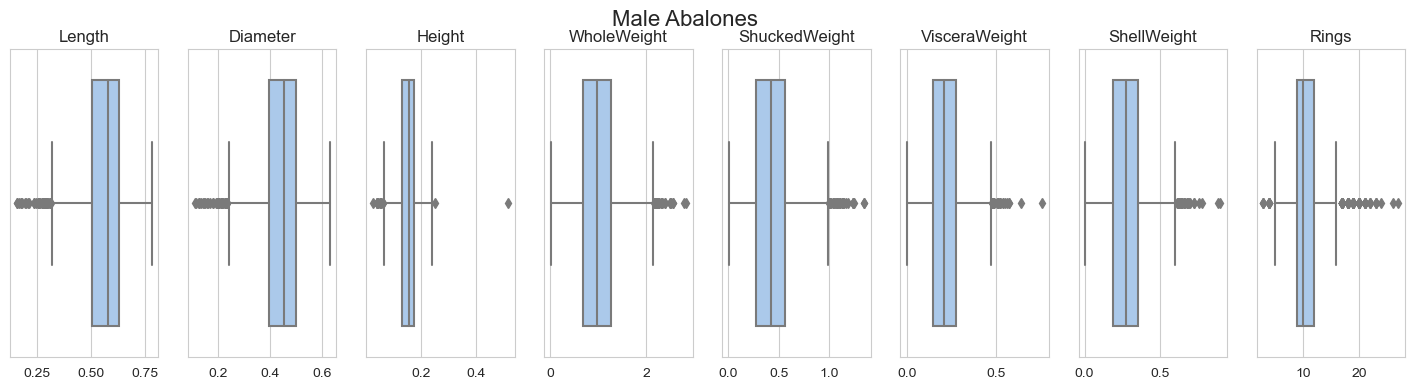

In [221]:

plot_boxplots(male_abalone, 'Male Abalones')

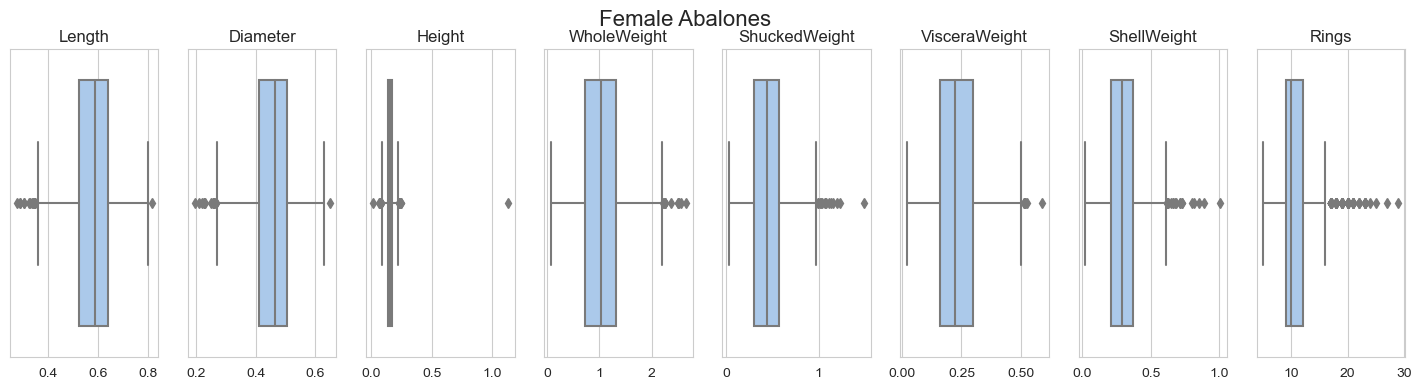

In [222]:
plot_boxplots(female_abalone, 'Female Abalones')

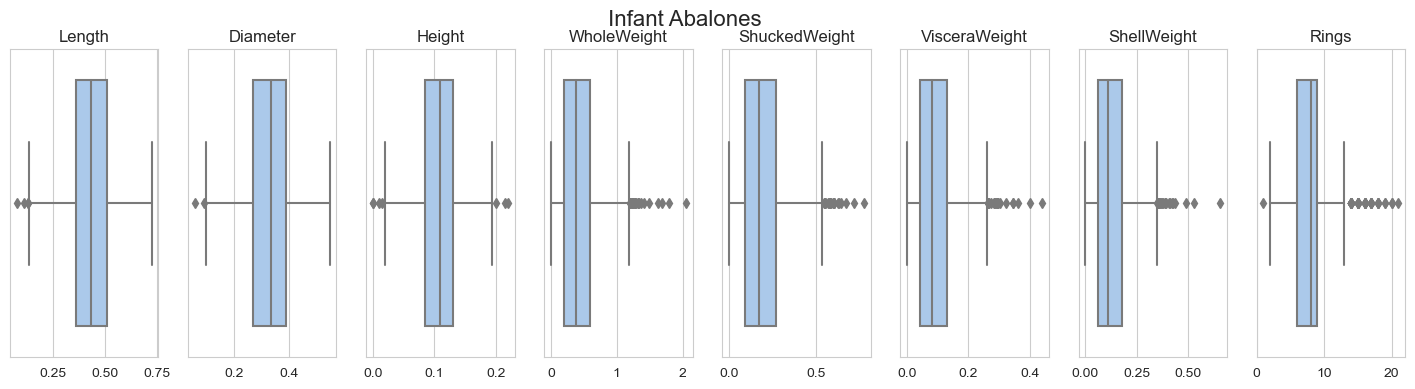

In [223]:
plot_boxplots(infant_abalone, 'Infant Abalones')

***There may be outliers in our data for each variable as indicated by boxplots***

In [224]:
# Defining a function for counting outliers
def count_outliers(data):
    outliers_count = {}
    for var in num_vars:
        Q1 = data[var].quantile(0.25)
        Q3 = data[var].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define criteria for an outlier
        is_outlier = (data[var] < (Q1 - 1.5 * IQR)) | (data[var] > (Q3 + 1.5 * IQR))
        
        # Count outliers
        outliers_count[var] = is_outlier.sum()
    return outliers_count

In [225]:
outliers_male = count_outliers(male_abalone)
outliers_female = count_outliers(female_abalone)
outliers_infant = count_outliers(infant_abalone)

In [226]:
outliers_male

{'Length': 41,
 'Diameter': 43,
 'Height': 15,
 'WholeWeight': 29,
 'ShuckedWeight': 30,
 'VisceraWeight': 22,
 'ShellWeight': 25,
 'Rings': 94}

In [227]:
outliers_female

{'Length': 15,
 'Diameter': 16,
 'Height': 23,
 'WholeWeight': 11,
 'ShuckedWeight': 14,
 'VisceraWeight': 8,
 'ShellWeight': 19,
 'Rings': 92}

In [228]:
outliers_infant

{'Length': 4,
 'Diameter': 2,
 'Height': 7,
 'WholeWeight': 21,
 'ShuckedWeight': 20,
 'VisceraWeight': 20,
 'ShellWeight': 20,
 'Rings': 49}

## 2.4 Removing Ourliers
for a more accurate modeling I decided to remove the outliers using the IQR method

In [177]:
def remove_outliers(data):
    filtered_data = data.copy()  # Create a copy of the data to avoid modifying the original dataframe
    for var in num_vars:  # Loop through each numerical variable defined in num_vars
        Q1 = data[var].quantile(0.25)  # 1st quartile
        Q3 = data[var].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Calculate IQR
        
        # Criteria for an outlier
        is_outlier = (data[var] < (Q1 - 1.5 * IQR)) | (data[var] > (Q3 + 1.5 * IQR))
        
        # Filter out outliers
        filtered_data = filtered_data[~is_outlier]  # Keeps only non-outlier data
    return filtered_data

In [178]:
male_abalone_clean = remove_outliers(male_abalone)
female_abalone_clean = remove_outliers(female_abalone)
infant_abalone_clean = remove_outliers(infant_abalone)

/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_2380/2573613166.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[~is_outlier]  # Keeps only non-outlier data
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_2380/2573613166.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[~is_outlier]  # Keeps only non-outlier data
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_2380/2573613166.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[~is_outlier]  # Keeps only non-outlier data
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_2380/2573613166.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[~is_outlier]  # Keeps only non-outlier data
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_2380/

In [179]:
(male_abalone.shape, male_abalone_clean.shape), (female_abalone.shape, female_abalone_clean.shape), (infant_abalone.shape, infant_abalone_clean.shape)

(((1528, 9), (1351, 9)), ((1307, 9), (1162, 9)), ((1342, 9), (1264, 9)))

In [180]:
# Concatenating the cleaned dataframes back into a single dataframe
abalone_clean = pd.concat([male_abalone_clean, female_abalone_clean, infant_abalone_clean], ignore_index=True)

# Before / After Clean
(abalone.shape, abalone_clean.shape)

((4177, 9), (3777, 9))

# 3. Encoding and converting Gender data
All of our variables are numerical beside Gender which can also be turned by encoding **0,1,2 -> male,female,infant**

In [181]:
encoder = LabelEncoder()
# Using the encoder's fit_transform method to encode the 'Sex' column
abalone_clean['Sex'] = encoder.fit_transform(abalone_clean['Sex'])
sex_counts = abalone_clean['Sex'].value_counts().sort_index()
sex_counts

0    1162
1    1264
2    1351
Name: Sex, dtype: int64

# 4. Normalization & Checking for Correlations
Normalizing our data for future when we are training our kNN model, however it does not affect the Pearson correlation coefficient

In [232]:
# Initialize the scaler
scaler = MinMaxScaler()

# Selecting the numerical features to be normalized
num_vars_to_scale = [ "Length", "Diameter", "Height", "WholeWeight", "ShuckedWeight", "VisceraWeight", "ShellWeight", "Rings"]

# Applying the scaler to the numerical features
abalone_clean_scaled = abalone_clean.copy()
abalone_clean_scaled[num_vars_to_scale] = scaler.fit_transform(abalone_clean[num_vars_to_scale])

# Calculating the correlation matrix for the normalized data
correlation_matrix_scaled = abalone_clean_scaled.corr()

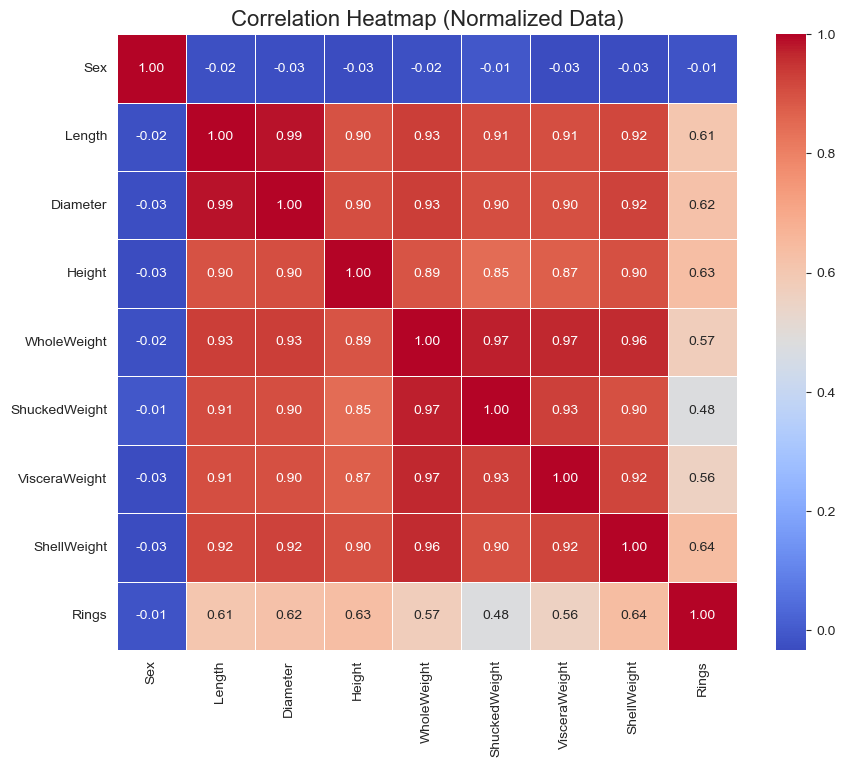

In [233]:
# Setting up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generating a heatmap
sns.heatmap(correlation_matrix_scaled, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f")


plt.title("Correlation Heatmap (Normalized Data)", fontsize=16)
plt.show()


***Almost all variables can be used as features since they have strong correlation with rings***

# 4. Modeling & Training

## 4.1 Linear Regression Model

In [246]:
# Features and target variable
features = abalone_clean_scaled.drop(columns=['Rings'])
target = abalone_clean_scaled['Rings']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Checking the shapes of the training and testing data
(X_train.shape, X_test.shape)

((3021, 8), (756, 8))

In [247]:
# Initializing model
linear_reg = LinearRegression()

# Training model
linear_reg.fit(X_train, y_train)

# Prediction
predictions_linear = linear_reg.predict(X_test)

# Evaluation
MAE_Linear = mean_absolute_error(y_test, predictions_linear)
MSE_Linear = mean_squared_error(y_test, predictions_linear)
R2_Linear = r2_score(y_test, predictions_linear)

R2_Linear, MSE_Linear, MAE_Linear

(0.5051788802332391, 0.016321199642806823, 0.0971390732059295)

### 4.1.2 Finding important features using the RFE technique

In [245]:
# Initializing RFE model
rfe = RFE(estimator=linear_reg, n_features_to_select=1, step=1)

# Fitting RFE model
rfe.fit(X_train, y_train)

# Getting the ranking of features
ranking = rfe.ranking_

# Creating a DataFrame to hold the ranking information
feature_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': ranking
}).sort_values(by='Ranking')

feature_ranking


,Feature,Ranking
4,WholeWeight,1
5,ShuckedWeight,2
2,Diameter,3
7,ShellWeight,4
3,Height,5
6,VisceraWeight,6
1,Length,7
0,Sex,8


## 4.2 Linear Regression Model (With Selective Features)

In [237]:
# Selecting the top 3 features based on RFE ranking
selected_features = ['WholeWeight', 'ShuckedWeight', 'Diameter']
selected_features_idx = [features.columns.get_loc(c) for c in selected_features]

# Creating new training and testing sets with selected features
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]

# Initializing and training the linear model with selected features
linear_reg_selected = LinearRegression()
linear_reg_selected.fit(X_train_selected, y_train)

# Predictions
predictions_selected = linear_reg_selected.predict(X_test_selected)

# Evaluation
MSE_selected = mean_squared_error(y_test, predictions_selected)
R2_selected = r2_score(y_test, predictions_selected)
MAE_selected = mean_absolute_error(y_test, predictions_selected)

R2_selected, MSE_selected, MAE_selected

(0.49169262528260926, 0.016766030816518188, 0.09864513934891432)

**Based on these metrics, the model before RFE (using all features) slightly outperforms the model after RFE (using selected features) in terms of all three metrics**

## 4.3 KNN Model (Before Tuning)

In [238]:
# Initializing model
knn_reg = KNeighborsRegressor(n_neighbors=5)

# Training model
knn_reg.fit(X_train, y_train)

# Prediction
predictions_knn = knn_reg.predict(X_test)

# Evaluation
MSE_K = mean_squared_error(y_test, predictions_knn)
R2_K = r2_score(y_test, predictions_knn)
MAE_K = mean_absolute_error(y_test, predictions_knn)

R2_K, MSE_K, MAE_K 

(0.48977002127523095, 0.016829446064139945, 0.09582388510959938)

### 4.3.1 Parameter Analysis of K value on our KNN Model and tuining it

In [239]:
k_values = np.arange(1, 51)

# Storing cross-validated scores
cv_scores_mean = []
cv_scores_std = []

# Performing cross-validation for each k value
for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    cv_scores = cross_val_score(knn_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores_mean.append(-cv_scores.mean())  # Storing mean score (negating because higher score is better)
    cv_scores_std.append(cv_scores.std())  # Storing standard deviation of scores

# Identifying the optimal k value
optimal_k = k_values[np.argmin(cv_scores_mean)]
print("Best k value is: ",optimal_k)

Best k value is:  18


## 4.4 KNN Model (After Tuning)

In [240]:
knn_reg = KNeighborsRegressor(n_neighbors=18)
knn_reg.fit(X_train, y_train)
predictions_knn = knn_reg.predict(X_test)

MSE_K = mean_squared_error(y_test, predictions_knn)
R2_K = r2_score(y_test, predictions_knn)
MAE_K = mean_absolute_error(y_test, predictions_knn)

R2_K, MSE_K, MAE_K 

(0.542693677179606, 0.015083810077038849, 0.09004682119761484)

**Model After Tuning: Shows improvement across all three metrics, after tuning the K value our KNN model showcases better results compared to the linear Regression model**

## 5. Conclusion

While the initial linear model exhibited superior metric values compared to KNN, the tuned KNN model ultimately outperformed linear regression in predicting the age of Abalones. Nevertheless, it is worth noting that altho both models have a somewhat reasonable degree of accuracy both fell short of achieving optimal performance in predicting Abalones' ages. Therefore, additional in-depth study and analysis are necessary.